In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import inspect,os
from itertools import islice
from functools import partial
from IPython import display
import urllib.request
from collections import OrderedDict,Counter
import re,copy
#import nltk,gensim,logging

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
import tensorflow_datasets as tfds

import torch
from torch.autograd import grad as torch_grad
import torch.nn as nn
from torch.utils.data import Dataset,TensorDataset,DataLoader
from torch.distributions.categorical import Categorical

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# **Custom LSTM from Scratch in PyTorch – Understanding Sequence Modeling Internals**

Epoch 0/20|  train_loss 23.0181|  train_acc 0.1006|  valid_loss 4.8247|  valid_acc 0.1670
Epoch 1/20|  train_loss 4.9995|  train_acc 0.1735|  valid_loss 4.6110|  valid_acc 0.1670
Epoch 2/20|  train_loss 1.8810|  train_acc 0.4751|  valid_loss 0.3058|  valid_acc 0.8400
Epoch 3/20|  train_loss 0.1837|  train_acc 0.9145|  valid_loss 0.0624|  valid_acc 0.9440
Epoch 4/20|  train_loss 0.0616|  train_acc 0.9707|  valid_loss 0.0249|  valid_acc 0.9800
Epoch 5/20|  train_loss 0.0314|  train_acc 0.9794|  valid_loss 0.0156|  valid_acc 0.9810
Epoch 6/20|  train_loss 0.0183|  train_acc 0.9921|  valid_loss 0.0070|  valid_acc 1.0000
Epoch 7/20|  train_loss 0.0129|  train_acc 0.9947|  valid_loss 0.0072|  valid_acc 1.0000
Epoch 8/20|  train_loss 0.0089|  train_acc 0.9950|  valid_loss 0.0030|  valid_acc 1.0000
Epoch 9/20|  train_loss 0.0092|  train_acc 0.9959|  valid_loss 0.0063|  valid_acc 1.0000
Epoch 10/20|  train_loss 0.0058|  train_acc 0.9988|  valid_loss 0.0039|  valid_acc 1.0000
Epoch 11/20|  train

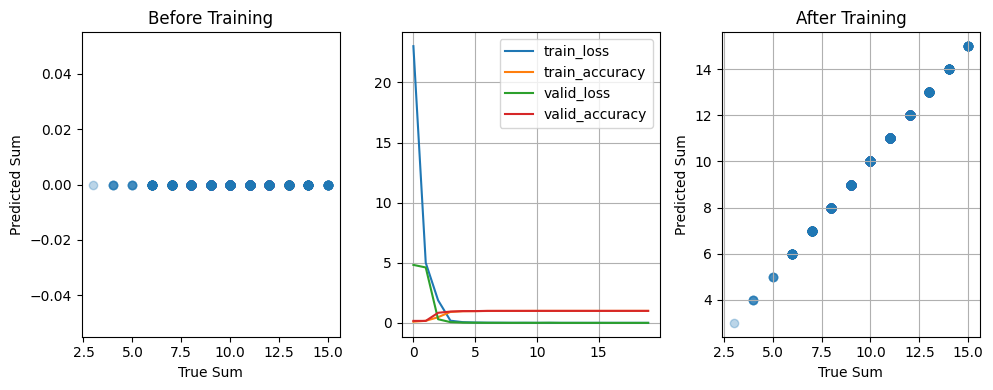

In [110]:
class LSTMCell(nn.Module): # This class builds an LSTM cell that can be used just like nn.LSTM
  def __init__(self,input_size,hidden_size):
    super(LSTMCell,self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size

    self.x_fc = nn.Linear(input_size,4*hidden_size)
    self.h_fc = nn.Linear(hidden_size,4*hidden_size)
    self.reset_parameters()

  def forward(self,x_t,hidden_cell_tuple): # updates the cell and hidden states at each time step
    h_t_1,c_t_1 = hidden_cell_tuple # h_t_1.shape = c_t_1.shape = [batch,hidden_size]
    # Change them to 2D so we can use safely nn.Linear
    x_t = x_t.view(-1,x_t.size(1)) # from [batch,t_s, embed_dim]  to [batch*t_s,embed] where t_s=1
   
    gates = self.x_fc(x_t) + self.h_fc(h_t_1)
    i_t,f_t,candidate_c_t,o_t = gates.chunk(4,1)

    i_t = torch.sigmoid(i_t)
    f_t = torch.sigmoid(f_t)
    o_t = torch.sigmoid(o_t)
    candidate_c_t = torch.tanh(candidate_c_t)
      
    c_t = (f_t * c_t_1) + (i_t * candidate_c_t)
    h_t = o_t * torch.tanh(c_t)
    return h_t,c_t
      
  def reset_parameters(self):
    for weight in self.parameters():
        if weight.dim() > 1:
            nn.init.xavier_uniform_(weight)
        else:
            nn.init.zeros_(weight)

class LSTMModel(nn.Module): # This class uses the LSTM block from above to create the actual model
  def __init__(self,input_size,hidden_size,output_dim,**kwargs):
    super().__init__(**kwargs)
    self.hidden_size = hidden_size
    self.lstm_cell = LSTMCell(input_size,hidden_size) # use above custome lstm to create the block
    self.fc = nn.Linear(hidden_size,output_dim)

  def forward(self,x):
    # Intialize cell and hidden states first
    device = x.device
    c_t = torch.zeros((x.size(0), self.hidden_size), device=device)
    h_t = torch.zeros((x.size(0), self.hidden_size), device=device)

    # Update cell and hidden states
    for t in range(x.size(1)): # go through the batch and pick values at each time step and evaluate
      h_t,c_t = self.lstm_cell(x[:,t,:],(h_t,c_t))
    return self.fc(h_t)
      
def train_model(model,loss_fn,optimizer,train_dl,test_dl,tolerance = 0.5):
    train_loss,train_accuracy = [],[]
    valid_loss,valid_accuracy = [],[]

    for epoch in range(EPOCHS):
        model.train()
        current_loss = 0
        current_accuracy = 0
        for x_batch,y_batch in train_dl:
            y_batch = y_batch.view(-1, 1)
            y_pred = model(x_batch)
            y_batch = y_batch
            y_pred = y_pred
            loss = loss_fn(y_pred,y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            current_loss += loss.item()*x_batch.size(0)
            #current_accuracy += (torch.abs(y_pred - y_batch) < tolerance).sum().item()
            # Accuracy fix: round predictions and compare to integer labels
            y_pred_int = torch.round(y_pred).long().view(-1)
            y_true_int = y_batch.long().view(-1)
            current_accuracy += (y_pred_int == y_true_int).sum().item()
        current_loss /= len(train_dl.dataset)
        current_accuracy /= len(train_dl.dataset)
        train_loss.append(current_loss)
        train_accuracy.append(current_accuracy)

        model.eval()
        current_loss = 0
        current_accuracy = 0
        for x_batch, y_batch in test_dl:
            y_batch = y_batch.view(-1, 1)
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            current_loss += loss.item() * x_batch.size(0)
            # Accuracy fix: round predictions and compare to integer labels
            y_pred_int = torch.round(y_pred).long().view(-1)
            y_true_int = y_batch.long().view(-1)
            current_accuracy += (y_pred_int == y_true_int).sum().item()    
        current_loss /= len(test_dl.dataset)
        current_accuracy /= len(test_dl.dataset)
        valid_loss.append(current_loss)
        valid_accuracy.append(current_accuracy)

        print(f'Epoch {epoch}/{EPOCHS}|  train_loss {train_loss[-1]:.4f}|  train_acc {train_accuracy[-1]:.4f}|'\
            f'  valid_loss {valid_loss[-1]:.4f}|  valid_acc {valid_accuracy[-1]:.4f}')
    return train_loss,train_accuracy,valid_loss,valid_accuracy


torch.manual_seed(2)

EPOCHS = 20  # training epochs
TRAINING_SAMPLES = 10000  # training dataset size
BATCH_SIZE = 16  # mini batch size
TEST_SAMPLES = 1000  # test dataset size
SEQUENCE_LENGTH = 20  # binary sequence length
HIDDEN_UNITS = 20  # hidden units of the LSTM cell

X_train = torch.randint(0,2,(TRAINING_SAMPLES,SEQUENCE_LENGTH,1)).float()
X_test = torch.randint(0,2,(TEST_SAMPLES,SEQUENCE_LENGTH,1)).float()
y_train = torch.sum(X_train,dim=1)
y_test = torch.sum(X_test,dim=1)

train_ds = TensorDataset(X_train,y_train)
test_ds = TensorDataset(X_test,y_test)
train_dl = DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
test_dl = DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=True)

model = LSTMModel(input_size=1,hidden_size=HIDDEN_UNITS,output_dim=1)
model_untrained = copy.deepcopy(model)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())#,lr=0.001)

train_loss,train_accuracy,valid_loss,valid_accuracy = train_model(model,loss_fn,optimizer,
                                                                  train_dl,test_dl,tolerance = 1)
history = {'train_loss':train_loss,'train_accuracy':train_accuracy,
               'valid_loss':valid_loss,'valid_accuracy':valid_accuracy}

plt.figure(figsize=(10,4))

# Subplot 1: Before Training
plt.subplot(1, 3, 1)
y_pred = model_untrained(X_test).detach().numpy().round()
y_true = y_test.numpy()
plt.scatter(y_true, y_pred, alpha=0.3)
plt.title("Before Training")
plt.xlabel('True Sum'); plt.ylabel('Predicted Sum')

# Subplot 2: Training History
ax2 = plt.subplot(1, 3, 2)
pd.DataFrame(history).plot(ax=ax2)  # Pass the subplot axes explicitly
plt.grid()

# Subplot 3: After Training
plt.subplot(1, 3, 3)
y_pred = model(X_test).detach().numpy().round()
y_true = y_test.numpy()
plt.scatter(y_true, y_pred, alpha=0.3)
plt.title("After Training")
plt.xlabel('True Sum'); plt.ylabel('Predicted Sum')

plt.tight_layout()
plt.grid()
plt.show()

# **Time Series Forecasting with a Custom LSTM Cell: Sine Wave Prediction**

Epoch 0/10 11.1651sec train_loss 0.1714 test_loss 0.5845


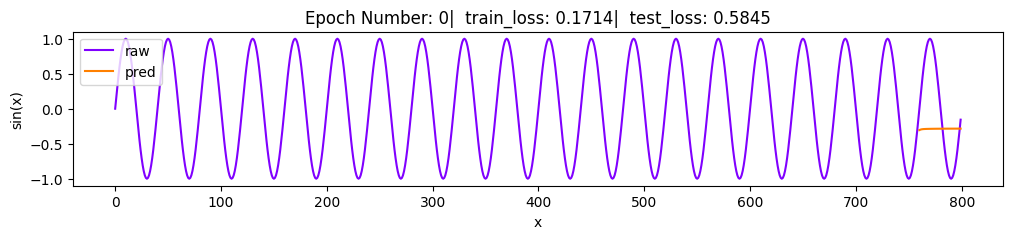

Epoch 1/10 11.7132sec train_loss 0.0403 test_loss 0.5105


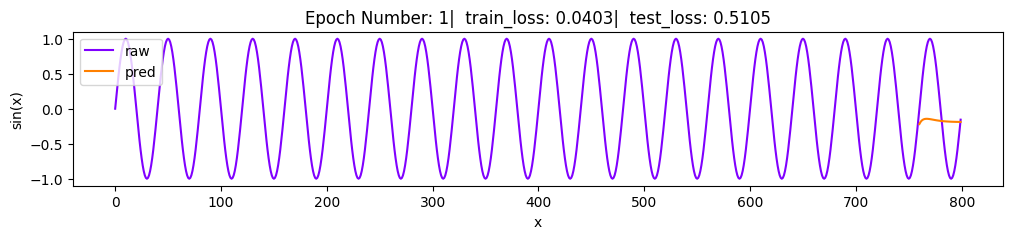

Epoch 2/10 11.2484sec train_loss 0.0165 test_loss 0.3083


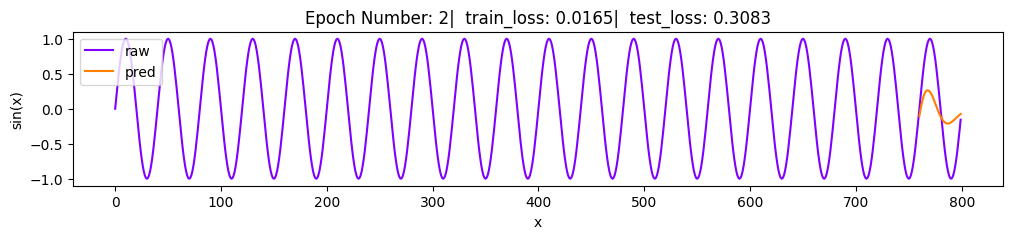

Epoch 3/10 11.2839sec train_loss 0.0028 test_loss 0.0387


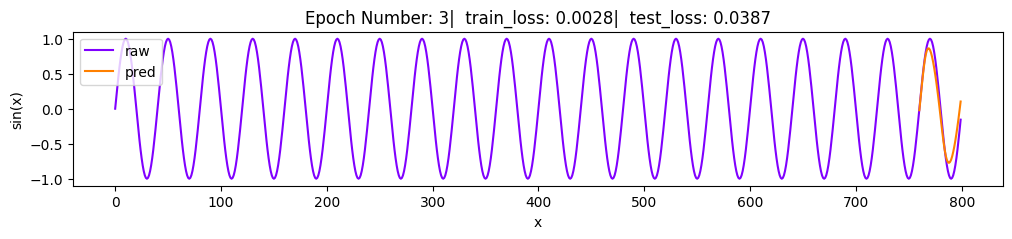

Epoch 4/10 11.8048sec train_loss 0.0006 test_loss 0.0053


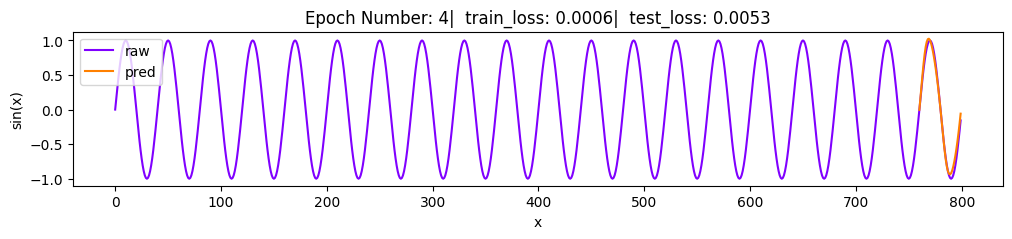

Epoch 5/10 10.4149sec train_loss 0.0005 test_loss 0.0038


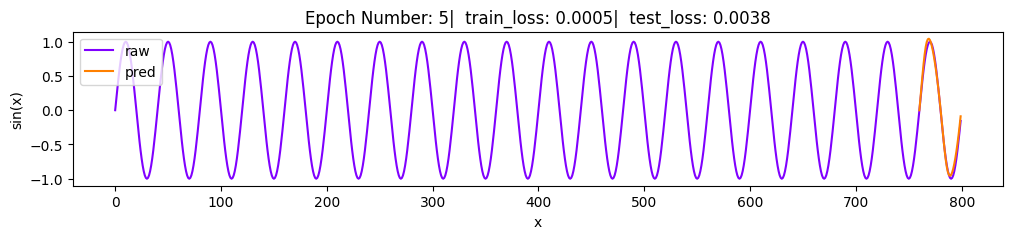

Epoch 6/10 11.3227sec train_loss 0.0005 test_loss 0.0035


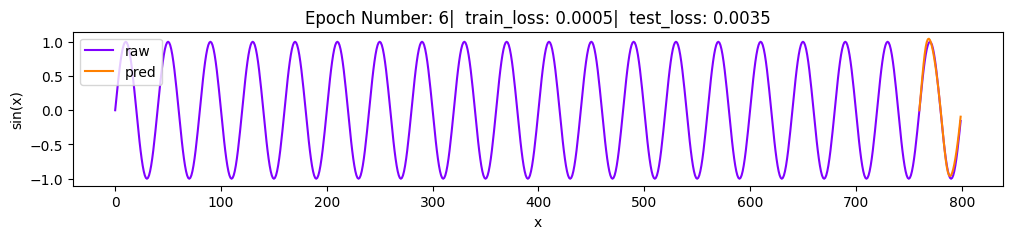

Epoch 7/10 10.8191sec train_loss 0.0005 test_loss 0.0033


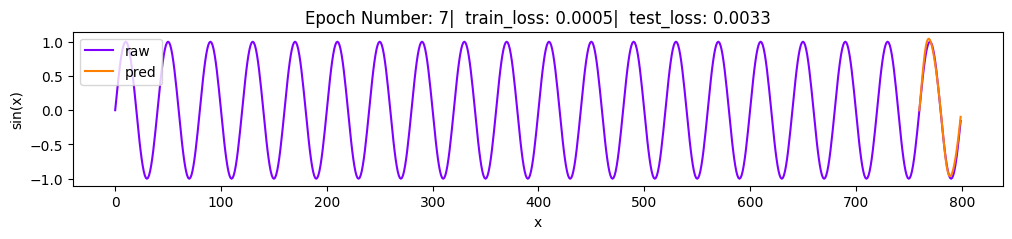

Epoch 8/10 10.6924sec train_loss 0.0004 test_loss 0.0032


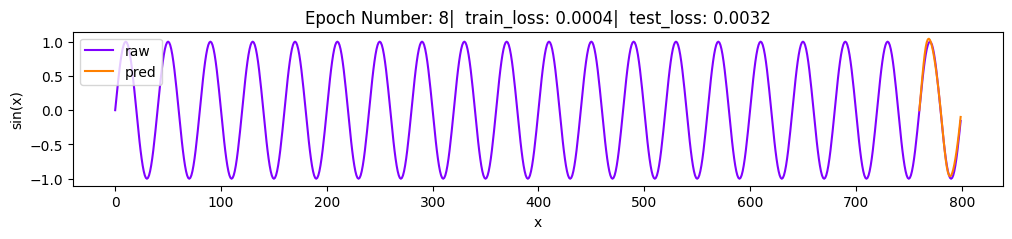

Epoch 9/10 11.1137sec train_loss 0.0004 test_loss 0.0031


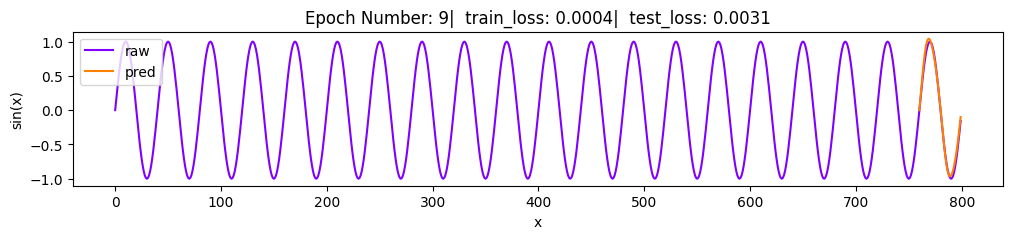

In [4]:
class LSTMCell(nn.Module): # This class builds an LSTM cell that can be used just like nn.LSTM
  def __init__(self,input_size,hidden_size):
    super(LSTMCell,self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size

    self.x_fc = nn.Linear(input_size,4*hidden_size)
    self.h_fc = nn.Linear(hidden_size,4*hidden_size)
    self.reset_parameters()

  def forward(self,x_t,hidden_cell_tuple): # updates the cell and hidden states at each time step
    h_t_1,c_t_1 = hidden_cell_tuple # h_t_1.shape = c_t_1.shape = [batch,hidden_size]
    # Change them to 2D so we can use safely nn.Linear
    x_t = x_t.view(-1,x_t.size(1)) # from [batch,t_s, embed_dim]  to [batch*t_s,embed] where t_s=1
   
    gates = self.x_fc(x_t) + self.h_fc(h_t_1)
    i_t,f_t,candidate_c_t,o_t = gates.chunk(4,1)

    i_t = torch.sigmoid(i_t)
    f_t = torch.sigmoid(f_t)
    o_t = torch.sigmoid(o_t)
    candidate_c_t = torch.tanh(candidate_c_t)
      
    c_t = (f_t * c_t_1) + (i_t * candidate_c_t)
    h_t = o_t * torch.tanh(c_t)
    return h_t,c_t
      
  def reset_parameters(self):
    for weight in self.parameters():
        if weight.dim() > 1:
            nn.init.xavier_uniform_(weight)
        else:
            nn.init.zeros_(weight)

class LSTMModel_Trig(nn.Module):
  def __init__(self,input_size=1,hidden_size=50,num_layers=1,output_dim=1):
    super().__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size

    self.lstm_cell = LSTMCell(input_size, hidden_size)
    self.fc = nn.Linear(hidden_size,output_dim)
      
  def forward(self,x):
    # Intialize cell and hidden states first
    device = x.device
    c_t = torch.zeros((x.size(0), self.hidden_size), device=device)
    h_t = torch.zeros((x.size(0), self.hidden_size), device=device)
    for t in range(x.size(1)): # go through the batch and pick values at each time step and evaluate
      h_t,c_t = self.lstm_cell(x[:,t,:],(h_t,c_t))
    return self.fc(h_t)

torch.manual_seed(20)
window_size = 40
num_epochs = 10

x = torch.linspace(0,799,800)
y = torch.sin(x*torch.pi*2/40)
y_train,y_test = y[:-40] ,y[-40:]

def input_data(data,window_size):
  data = data.tolist()
  slide_data = []
  for i in range(len(data)-window_size):
    slide_data.append((torch.tensor(data[i:i+window_size]),torch.tensor(data[i+window_size:i+window_size+1])))
  return slide_data
    
train_data = input_data(y_train,window_size)

model=LSTMModel_Trig(input_size=1,hidden_size=50,num_layers=1,output_dim=1)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)

for epoch in range(num_epochs):
  train_loss = 0.0
  start = time.time()
  model.train()
  for x_batch,y_batch in train_data:
    x_batch = x_batch.view(1,window_size,1)
    y_pred = model(x_batch)[0]
    loss = loss_fn(y_pred,y_batch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    train_loss += loss.item()
  train_loss = train_loss/len(train_data)
  sample_input = y_train[-window_size:].tolist()
  for i in range(window_size):
    sample_input.append(model(torch.tensor(sample_input[-window_size:]).view(1,window_size,1)).item())
  test_loss = loss_fn(torch.tensor(sample_input[-window_size:]),y_train[-window_size:])
  print(f'Epoch {epoch}/{num_epochs} {time.time()- start:.4f}sec train_loss {train_loss:.4f} test_loss {test_loss:.4f}')
  plt.figure(figsize=(12,2))
  plt.plot(y,color='#8000ff')
  plt.plot(range(760,800),sample_input[-window_size:],color='#ff8000')
  plt.legend(['raw','pred'],loc='upper left')
  plt.title(f'Epoch Number: {epoch}|  train_loss: {train_loss:.4f}|  test_loss: {test_loss:.4f}')
  plt.xlabel('x');plt.ylabel('sin(x)')
  plt.show()

# **GRU From Scratch On Sentiment Analysis Dataset**

**Both Custom and Pytorch Built-in Models**

In [3]:
# Both Custom and Pytorch Built-in Models

class GRUCell(nn.Module):
    def __init__(self, input_dim, hidden_units):
        super().__init__()
        self.hidden_units = hidden_units
        self.fc_x = nn.Linear(input_dim, 3 * hidden_units)
        self.fc_h = nn.Linear(hidden_units, 3 * hidden_units)
        self.reset_parameters()

    def forward(self, x, hidden_state):
        # Compute all gates at once
        x_proj = self.fc_x(x)
        h_proj = self.fc_h(hidden_state)
        r_x, z_x, n_x = x_proj.chunk(3, dim=1)
        r_h, z_h, n_h = h_proj.chunk(3, dim=1)
        r = torch.sigmoid(r_x + r_h)
        z = torch.sigmoid(z_x + z_h)
        n = torch.tanh(n_x + r * n_h)
        h_t = (1 - z) * n + z * hidden_state
        return h_t
    def reset_parameters(self):
        for weight in self.parameters():
            if weight.dim() > 1:
                nn.init.xavier_uniform_(weight)
            else:
                nn.init.zeros_(weight)

class GRUModel(nn.Module): # Padding index aware logic is included in this model
    def __init__(self, input_size, hidden_size, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden_size = hidden_size
        self.gru_cell = GRUCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_dim)
        
    def forward(self, x, lengths):
        batch_size, seq_len, _ = x.size()
        h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
        for t in range(seq_len):
            mask = (t < lengths).float().unsqueeze(1)  # shape (batch_size, 1)
            h_t_new = self.gru_cell(x[:, t, :], h_t)
            h_t = h_t_new * mask + h_t * (1 - mask)   # Update hidden state only where mask=1, else keep previous h_t
        return self.fc(h_t)

class GRU_Sentiment_Analysis(nn.Module):
  def __init__(self,vocab_size,embed_dim,gru_hidden_size,fc_hidden_size,**kwargs):
    super().__init__(**kwargs)
    self.embedding = nn.Embedding(num_embeddings=vocab_size,embedding_dim=embed_dim,padding_idx=0)
    self.gru = GRUModel(input_size=embed_dim,hidden_size=gru_hidden_size,output_dim=fc_hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(fc_hidden_size,1)
    self.sigmoid = nn.Sigmoid()

  def forward(self,text,lengths):
    out = self.embedding(text)
    out= self.gru(out,lengths)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.sigmoid(out)
    return out
      
##### To compare custom performance, and show know how to use Pytorch Models #####

class BidirectionalGRU(nn.Module):
  def __init__(self,vocab_size,embed_dim,rnn_hidden_size,fc_hidden_size,**kwargs):
    super().__init__(**kwargs)

    self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=0)
    self.rnn = nn.GRU(input_size=embed_dim, hidden_size=rnn_hidden_size,
                      batch_first=True, num_layers=1, bidirectional=True)
    self.fc1 = nn.Linear(rnn_hidden_size * 2, fc_hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(fc_hidden_size, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, text, lengths):
    out = self.embedding(text)
    out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), batch_first=True, enforce_sorted=False)
    out, hidden = self.rnn(out)
    # hidden shape: (num_layers * num_directions, batch, hidden_size)
    # For bidirectional GRU with 1 layer, hidden has shape (2, batch, hidden_size)
    hidden = torch.cat([hidden[0], hidden[1]], dim=1)  # concatenate forward and backward hidden states
    out = self.fc1(hidden)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.sigmoid(out)
    return out

class GRULeftToRight(nn.Module):
  def __init__(self,vocab_size,embed_dim,rnn_hidden_size,fc_hidden_size,**kwargs):
    super().__init__(**kwargs)

    self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=0)
    self.rnn = nn.GRU(input_size=embed_dim, hidden_size=rnn_hidden_size, batch_first=True, num_layers=1)
    self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(fc_hidden_size, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, text, lengths):
    out = self.embedding(text)
    out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), batch_first=True, enforce_sorted=False)
    out, hidden = self.rnn(out)
    out = self.fc1(hidden[-1])
    out = self.relu(out)
    out = self.fc2(out)
    out = self.sigmoid(out)
    return out

**Preprocess data and Prepare dataloader**

In [4]:
# Preprocess data and Prepare dataloader

SEED = 11   
np.random.seed(SEED)
torch.manual_seed(SEED)
BATCH_SIZE = 32

def word_to_int(text,label):
    num = []
    tokenized = tokenizer(text)
    for item in tokenized:
      if item in vocab:             #token_counts:
        num.append(vocab[item])     #(token_counts[item])
      else:
        num.append(vocab["<unk>"])
    return num, label_to_int(label)

def tokenizer(text): # Split the text into words only, no punctuation marks
    text = re.sub('<[^>]*>', '', text) # Remove the HTML syntax if found
    #text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', '')
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +' '.join(emoticons).replace('-', '')
    tokenized = text.split()
    return tokenized
    
class MyDataset(Dataset):
  def __init__(self,x,y,**kwargs):
    super().__init__(**kwargs)
    self.x,self.y = x,y
  def __len__(self):
    return len(self.y)
  def __getitem__(self, index):
    return self.x[index],self.y[index]

def collate_batch(batch):
  label_list,text_list,lengths = [],[],[]
  for text_,label_ in batch:
    _text,_label = word_to_int(text_,label_)
    label_list.append(_label)
    text_list.append(torch.tensor(_text,dtype=torch.int64))
    lengths.append(len(_text))
  label_list = torch.tensor(label_list)
  lengths = torch.tensor(lengths)
  padded_text_list = nn.utils.rnn.pad_sequence(text_list,batch_first=True)
  return padded_text_list,label_list,lengths

dataset = pd.read_csv("hf://datasets/scikit-learn/imdb/IMDB Dataset.csv")
#Split the dataset into train,valid and test
a = np.arange(len(dataset))
train_split = np.random.choice(a,25000,replace=False)
test_split = [b for b in a if b not in train_split]
train_dataset = dataset.iloc[train_split]
train_dataset,valid_dataset = train_dataset[:20000],train_dataset[20000:]

# Get a list of the values for input and label in the text form for preprocessing procedure
# Sentiment is the label/target
train_sentiment = train_dataset.pop('sentiment').values
train_text = train_dataset.pop('review').values
valid_sentiment = valid_dataset.pop('sentiment').values
valid_text = valid_dataset.pop('review').values

token_counts = Counter() # Unique word counts/ unique words apperance times
for text in train_text:
  token = tokenizer(text)
  token_counts.update(token)
sorted_by_frequency = sorted(token_counts.items(),key = lambda x:x[1],reverse=True) # a list with word:apperance
sorted_by_frequency.insert(0,("<pad>",0))  # insert this at position 0
sorted_by_frequency.insert(1,("<unk>",1))
ord_dict = OrderedDict(sorted_by_frequency) # from list convert to dict so to uses words as keys
vocab = dict(zip(list(ord_dict.keys()),range(len(ord_dict)))) # build the vocablary with word:index

text_to_int = lambda text: [vocab[token] if token in vocab else vocab["<unk>"] for token in tokenizer(text)]
label_to_int = lambda x: 1. if x=='positive' else 0.

train_ds = MyDataset(train_text,train_sentiment)
valid_ds = MyDataset(valid_text,valid_sentiment)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

**Model Training And Result Plotting Utility Functions**

In [7]:
#Model Training And Result Plotting Utility Function

def plot_confusion_matrix(model, dataloader_, labels=['Negative', 'Positive'], 
                          normalize=False, title='Confusion Matrix'):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for x, y, lengths in dataloader_:
            x = x.to(next(model.parameters()).device)
            y = y.to(next(model.parameters()).device).float()
            lengths = lengths.to(next(model.parameters()).device)
            preds = model(x,lengths).squeeze(-1)
            preds = (preds >= 0.5).float()
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(y.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred, normalize='true' if normalize else None)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f' if normalize else 'd')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
def grad_norm(model):
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    return total_norm ** 0.5

def train(model,loss_fn,optimizer,dataloader):
  model.train()
  total_accuracy,total_loss = 0.0,0.0
  for text_batch, label_batch,lengths in dataloader:
    text_batch,label_batch,lengths = text_batch.to(device),label_batch.to(device),lengths.to(device)
    pred = model(text_batch,lengths)[:,0]
    loss = loss_fn(pred,label_batch)
    loss.backward()
    norm_grad = grad_norm(model)
    optimizer.step()
    optimizer.zero_grad()
    total_accuracy += ((pred >= 0.5).float() == label_batch).sum().item()
    total_loss += loss.item()*label_batch.size(0)
  return total_accuracy/len(dataloader.dataset),total_loss/len(dataloader.dataset),norm_grad

def evaluate(model,loss_fn,dataloader):
  model.eval()
  total_accuracy,total_loss = 0.0,0.0
  with torch.no_grad():
    for text_batch,label_batch,lengths in dataloader:
      text_batch,label_batch,lengths = text_batch.to(device),label_batch.to(device),lengths.to(device)
      pred = model(text_batch,lengths)[:,0]
      loss = loss_fn(pred,label_batch)
      total_accuracy += ((pred >= 0.5).float() == label_batch).sum().item()
      total_loss += loss.item()*label_batch.size(0)
  return total_accuracy/len(dataloader.dataset),total_loss/len(dataloader.dataset)

def train_each_models(model,loss_fn,optimizer,train_dl,valid_dl,NUM_EPOCHS=10):
    train_acc,train_loss = [],[]
    valid_acc,valid_loss = [],[]
    for epoch in range(NUM_EPOCHS):
        start = time.time()
        acc_train, loss_train,norm_grad = train(model,loss_fn,optimizer,train_dl)
        acc_valid, loss_valid = evaluate(model,loss_fn,valid_dl)
    
        train_acc.append(acc_train)
        train_loss.append(loss_train)
        valid_acc.append(acc_valid)
        valid_loss.append(loss_valid)
        elapsed = time.time() - start
        print(f"Epoch {epoch}/{NUM_EPOCHS} | Time: {elapsed:.2f}s | "
                  f"Train Acc:{acc_train:.4f}| Train Loss:{loss_train:.4f}| "
                  f"Valid Acc:{acc_valid:.4f}| Valid Loss:{loss_valid:.4f}| Grad norm:{norm_grad:.2f}")    
    return train_acc, train_loss,valid_acc,valid_loss

**Train Custom GRU**

Epoch 0/10 | Time: 579.69s | Train Acc:0.6299| Train Loss:0.6332| Valid Acc:0.6794| Valid Loss:0.6114| Grad norm:0.44
Epoch 1/10 | Time: 576.48s | Train Acc:0.7611| Train Loss:0.5005| Valid Acc:0.6928| Valid Loss:0.5738| Grad norm:0.59
Epoch 2/10 | Time: 568.81s | Train Acc:0.8273| Train Loss:0.3976| Valid Acc:0.8216| Valid Loss:0.4047| Grad norm:0.60
Epoch 3/10 | Time: 576.19s | Train Acc:0.8832| Train Loss:0.2914| Valid Acc:0.8528| Valid Loss:0.3573| Grad norm:3.04
Epoch 4/10 | Time: 571.62s | Train Acc:0.9127| Train Loss:0.2301| Valid Acc:0.8528| Valid Loss:0.3757| Grad norm:1.83
Epoch 5/10 | Time: 573.00s | Train Acc:0.9373| Train Loss:0.1753| Valid Acc:0.8618| Valid Loss:0.3400| Grad norm:2.02
Epoch 6/10 | Time: 573.09s | Train Acc:0.9536| Train Loss:0.1351| Valid Acc:0.8684| Valid Loss:0.3715| Grad norm:1.39
Epoch 7/10 | Time: 550.78s | Train Acc:0.9679| Train Loss:0.0994| Valid Acc:0.8688| Valid Loss:0.3749| Grad norm:1.07
Epoch 8/10 | Time: 541.98s | Train Acc:0.9783| Train Los

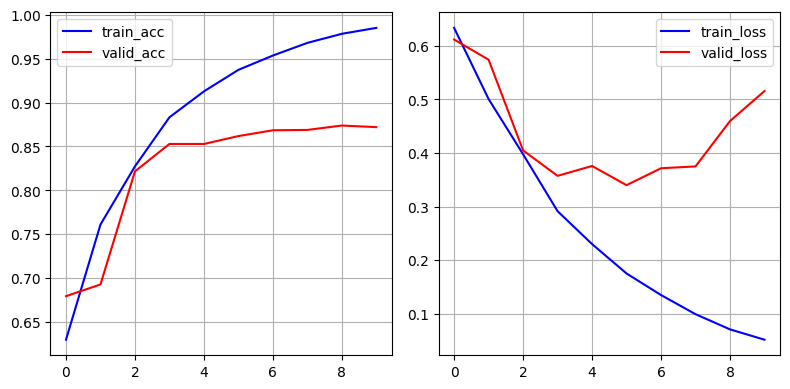

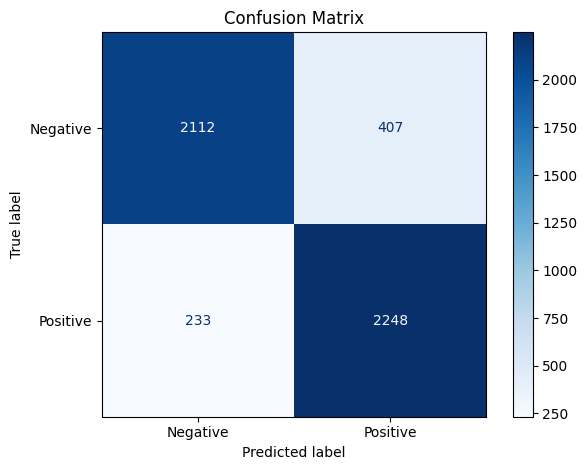

In [9]:
torch.manual_seed(1)

vocab_size = len(vocab)
embed_dim = 20
rnn_hidden_size=64
fc_hidden_size=64

model = GRU_Sentiment_Analysis(vocab_size,embed_dim,rnn_hidden_size,fc_hidden_size).to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.BCELoss()

NUM_EPOCHS = 10
train_acc,train_loss,valid_acc,valid_loss = train_each_models(model,loss_fn,optimizer,train_dl,valid_dl,NUM_EPOCHS)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(train_acc,color='blue',label='train_acc')
plt.plot(valid_acc,color='red',label='valid_acc')
plt.legend();plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_loss,color='blue',label='train_loss')
plt.plot(valid_loss,color='red',label='valid_loss')
plt.legend();plt.grid(True);plt.tight_layout()
plt.show()

plot_confusion_matrix(model, valid_dl)
plt.show()

**Train Uni-Directional GRU**

Epoch 0/10 | Time: 27.37s | Train Acc:0.6264| Train Loss:0.6364| Valid Acc:0.7340| Valid Loss:0.5402| Grad norm:0.62
Epoch 1/10 | Time: 26.22s | Train Acc:0.7902| Train Loss:0.4573| Valid Acc:0.8152| Valid Loss:0.4273| Grad norm:1.09
Epoch 2/10 | Time: 26.09s | Train Acc:0.8577| Train Loss:0.3406| Valid Acc:0.8138| Valid Loss:0.4237| Grad norm:1.25
Epoch 3/10 | Time: 26.19s | Train Acc:0.9041| Train Loss:0.2479| Valid Acc:0.8572| Valid Loss:0.3464| Grad norm:1.45
Epoch 4/10 | Time: 25.71s | Train Acc:0.9273| Train Loss:0.1952| Valid Acc:0.8594| Valid Loss:0.3269| Grad norm:0.46
Epoch 5/10 | Time: 25.73s | Train Acc:0.9446| Train Loss:0.1549| Valid Acc:0.8680| Valid Loss:0.3282| Grad norm:0.65
Epoch 6/10 | Time: 26.11s | Train Acc:0.9609| Train Loss:0.1130| Valid Acc:0.8688| Valid Loss:0.3584| Grad norm:1.17
Epoch 7/10 | Time: 25.80s | Train Acc:0.9742| Train Loss:0.0819| Valid Acc:0.8662| Valid Loss:0.4280| Grad norm:4.05
Epoch 8/10 | Time: 25.63s | Train Acc:0.9801| Train Loss:0.0657|

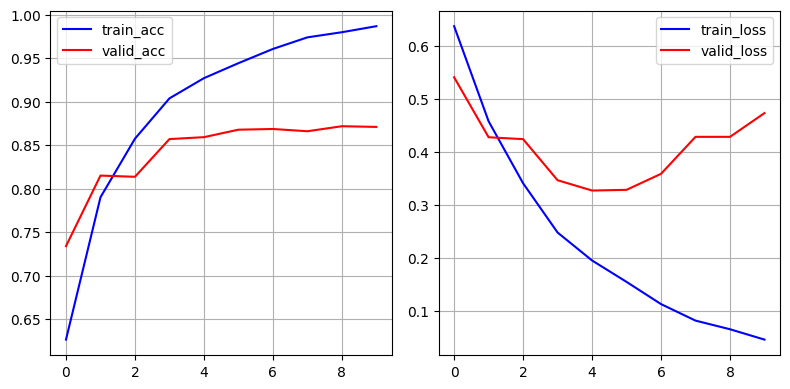

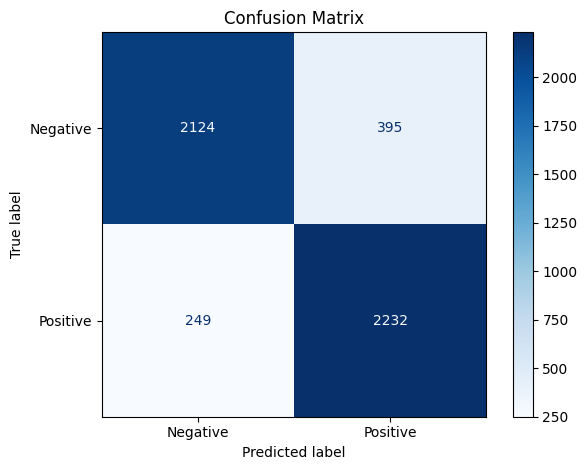

In [8]:
torch.manual_seed(2)

vocab_size = len(vocab)
embed_dim = 20
rnn_hidden_size=64
fc_hidden_size=64

model = GRULeftToRight(vocab_size,embed_dim,rnn_hidden_size,fc_hidden_size).to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.BCELoss()

NUM_EPOCHS = 10
train_acc,train_loss,valid_acc,valid_loss = train_each_models(model,loss_fn,optimizer,train_dl,valid_dl,NUM_EPOCHS)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(train_acc,color='blue',label='train_acc')
plt.plot(valid_acc,color='red',label='valid_acc')
plt.legend();plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_loss,color='blue',label='train_loss')
plt.plot(valid_loss,color='red',label='valid_loss')
plt.legend();plt.grid(True);plt.tight_layout()
plt.show()

plot_confusion_matrix(model, valid_dl)
plt.show()

**Train Bidirectional GRU Model**

Epoch 0/10 | Time: 38.42s | Train Acc:0.5800| Train Loss:0.6735| Valid Acc:0.6324| Valid Loss:0.6516| Grad norm:1.79
Epoch 1/10 | Time: 38.42s | Train Acc:0.6842| Train Loss:0.5871| Valid Acc:0.7290| Valid Loss:0.5396| Grad norm:2.56
Epoch 2/10 | Time: 39.39s | Train Acc:0.8186| Train Loss:0.4014| Valid Acc:0.8326| Valid Loss:0.3752| Grad norm:1.41
Epoch 3/10 | Time: 38.78s | Train Acc:0.8811| Train Loss:0.2838| Valid Acc:0.8504| Valid Loss:0.3522| Grad norm:0.90
Epoch 4/10 | Time: 38.73s | Train Acc:0.9146| Train Loss:0.2143| Valid Acc:0.8536| Valid Loss:0.3499| Grad norm:1.10
Epoch 5/10 | Time: 38.71s | Train Acc:0.9407| Train Loss:0.1632| Valid Acc:0.8754| Valid Loss:0.3133| Grad norm:1.23
Epoch 6/10 | Time: 37.97s | Train Acc:0.9587| Train Loss:0.1195| Valid Acc:0.8826| Valid Loss:0.3215| Grad norm:1.38
Epoch 7/10 | Time: 37.86s | Train Acc:0.9718| Train Loss:0.0863| Valid Acc:0.8810| Valid Loss:0.3734| Grad norm:0.36
Epoch 8/10 | Time: 37.39s | Train Acc:0.9830| Train Loss:0.0587|

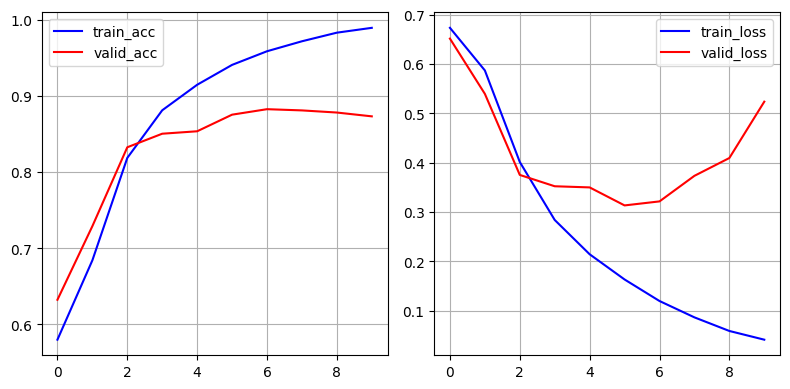

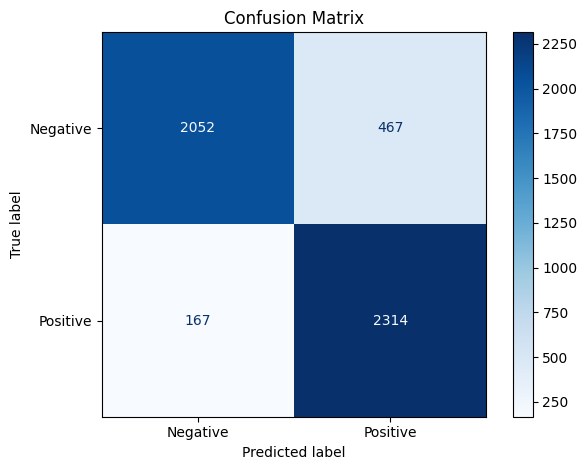

In [10]:
torch.manual_seed(3)
vocab_size = len(vocab)
embed_dim = 20
rnn_hidden_size=64
fc_hidden_size=64

model = BidirectionalGRU(vocab_size,embed_dim,rnn_hidden_size,fc_hidden_size).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.BCELoss()

train_acc,train_loss,valid_acc,valid_loss = train_each_models(model,loss_fn,optimizer,train_dl,valid_dl)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(train_acc,color='blue',label='train_acc')
plt.plot(valid_acc,color='red',label='valid_acc')
plt.legend();plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_loss,color='blue',label='train_loss')
plt.plot(valid_loss,color='red',label='valid_loss')
plt.legend();plt.grid(True);plt.tight_layout()
plt.show()

plot_confusion_matrix(model, valid_dl)
plt.show()

# **Charcter Level Text Generation**

Dataset length: 1112267 characters
Vocab size: 80 unique characters
Epoch 0/5| time_elapsed:654.765s| train_loss: 1.2805| valid_loss: 1.1837| grad_norm: 7.8862
Epoch 4/5| time_elapsed:659.440s| train_loss: 1.1269| valid_loss: 1.1306| grad_norm: 6.8033
Generated texts by the model shown below:

1. Generate text using greedy method:
The island, and the sea was the settlers were already enough to the shore, the settlers were already explored the sailor and his companions were stranger and the sea was the settlers were already enough to the shore, the settlers were already explored the sailor and his companions were stranger and the sea was the settlers were already enough to the shore, the settlers were already explored the sailor and his companions were stranger and the sea was the settlers were already enough to the shore, the settl
################################################################################
2. Generate text using random method with temperature = 1.0:
The island
sou

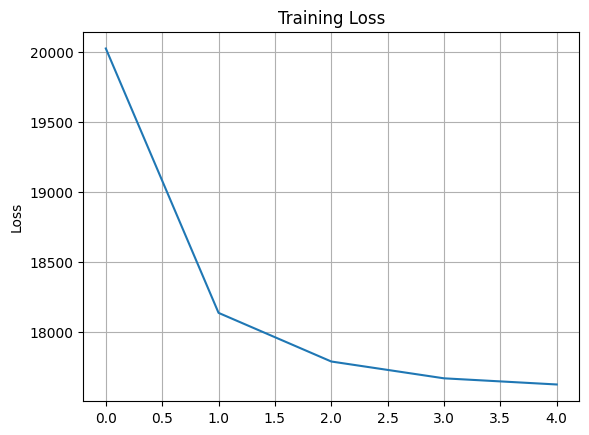

In [4]:
# Dataset is imported and preprocessed here
SEED = 10
SEQUENCE_LENGTH = 30
BATCH_SIZE = 64
NUM_EPOCHS = 5
EMBED_DIM = 256
RNN_HIDDEN_SIZE = 512
LEARNING_RATE = 0.001

torch.manual_seed(SEED)
!wget -q https://www.gutenberg.org/files/1268/1268-0.txt
with open("/kaggle/working/1268-0.txt",'r',encoding="utf8") as fp:
    text = fp.read()
    
start_index = text.find("THE MYSTERIOUS ISLAND")
end_index = text.find("END OF THE PROJECT GUTENBERG EBOOK 1268")
text = text[start_index:end_index]

char_set = set(text) # All the unique charactes found in the text doc
char_sorted = sorted(char_set)
char2int = {ch:i for i,ch in enumerate(char_sorted)}  # Dictionary containing char:index
char_array = np.array(char_sorted) # Converting int to char (int2char),i.e, given index, get the char
vocab = char2int
text_encoded = np.array([char2int[ch] for ch in text], dtype=np.int32) #Replace all char in input to an array of int

chunk_size = SEQUENCE_LENGTH + 1
text_chunks = [text_encoded[i:chunk_size+i] for i in range(len(text_encoded)-chunk_size+1)]

class TextDataset(Dataset):
  def __init__(self,x,**kwargs):
    super().__init__(**kwargs)
    self.text_chunk = x
  def __len__(self):
    return len(self.text_chunk)
  def __getitem__(self,index):
    chunk = self.text_chunk[index]
    return torch.tensor(chunk[:-1],dtype=torch.long),torch.tensor(chunk[1:],dtype=torch.long)

seq_dataset = TextDataset(text_chunks)
#seq_dl = DataLoader(seq_dataset,batch_size=BATCH_SIZE,shuffle=True,drop_last=True) 

# Create train/valid split
train_size = int(0.9 * len(seq_dataset))
valid_size = len(seq_dataset) - train_size
train_ds, valid_ds = torch.utils.data.random_split(seq_dataset, [train_size, valid_size])
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, drop_last=True)


#The above steps conclude data preprocessing task. Next the model to be trained is creted

def get_next_text(text, vocab=char2int):
    tokens = torch.tensor([vocab[i] for i in text]).to(device)
    model.eval()
    hidden, cell = model.init_hidden(1)
    hidden, cell = hidden.to(device), cell.to(device)
    for i in range(len(tokens)):
        input_ = tokens[i:i+1]
        out, hidden, cell = model(input_, hidden, cell)
    y_pred = torch.argmax(out, dim=1).item()
    return char_array[y_pred]

def generate_text(text, char_length=50):
    for _ in range(char_length):
        text += get_next_text(text)
    return text

def random_next_text(text, char_length=50, scale_factor=1, vocab=char2int):
    for _ in range(char_length):
        tokens = torch.tensor([vocab[i] for i in text]).to(device)
        model.eval()
        hidden, cell = model.init_hidden(1)
        hidden, cell = hidden.to(device), cell.to(device)
        
        for i in range(len(tokens)):
            input_ = tokens[i:i+1]
            out, hidden, cell = model(input_, hidden, cell)

        m = Categorical(logits=out * scale_factor)
        y_pred = m.sample((1,)).item()
        text += char_array[y_pred]
    return text

class RNN_CHAR_GEN_MODEL(nn.Module):
  def __init__(self,vocab_size,embed_dim, rnn_hidden_size,**kwargs):
    super().__init__(**kwargs)
    self.rnn_hidden_size = rnn_hidden_size
    self.embedding = nn.Embedding(num_embeddings=vocab_size,embedding_dim=embed_dim)
    self.rnn = nn.LSTM(embed_dim,rnn_hidden_size,batch_first=True)
    self.fc = nn.Linear(rnn_hidden_size,vocab_size)

  def forward(self,x,hidden,cell):
    # calculation is done per time step and that is why hidden and cell is sent back
    out = self.embedding(x).unsqueeze(1) # new dimension is add so the output would be transformed from 2D to 3D
    out,(hidden,cell) = self.rnn(out,(hidden,cell))
    out = self.fc(out).reshape(out.size(0),-1)
    return out, hidden,cell

  def init_hidden(self,batch_size):
    # For each batch, we first initialize hidden and cell
    hidden = torch.zeros(1,batch_size,self.rnn_hidden_size)
    cell = torch.zeros(1,batch_size,self.rnn_hidden_size)
    return hidden,cell


def grad_norm(model):
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    return total_norm ** 0.5

def train_model(model,loss_fn,optimizer,train_dl,valid_dl,num_epochs,sequence_length,device = device):
    train_losses = []
    def evaluate(x_batch,y_batch,train=True):
        
        model.train() if train else model.eval()
        batch_size = x_batch.size(0)
        hidden, cell = model.init_hidden(batch_size) # initialize cell and hidden state
        hidden = hidden.to(device)
        cell = cell.to(device)
        loss = 0.0
        if train:
            optimizer.zero_grad()
        for c in range(sequence_length):
            input_ = x_batch[:, c].to(device)
            pred, hidden, cell = model(input_, hidden, cell)
            hidden = hidden.detach()
            cell = cell.detach()
            y_batch_step= y_batch[:, c].to(device)
            loss += loss_fn(pred, y_batch_step)
        if train:
            loss.backward()
            optimizer.step()
        return loss.item()/sequence_length

    for epoch in range(num_epochs):
        start = time.time()
        train_epoch_loss = 0.0
        for x_batch,y_batch in train_dl:
            train_epoch_loss += evaluate(x_batch,y_batch,train=True)
        train_losses.append(train_epoch_loss)
        
        if epoch % 5 == 0 or epoch == num_epochs - 1:
    
            valid_epoch_loss = 0.0
            with torch.no_grad():
                for x_batch,y_batch in valid_dl:
                    valid_epoch_loss += evaluate(x_batch,y_batch,train=False)
                    
            train_epoch_loss /= len(train_dl)
            valid_epoch_loss /= len(valid_dl)
            elapsed = time.time()-start
            norm_grad = grad_norm(model)
            print(f'Epoch {epoch}/{num_epochs}| time_elapsed:{elapsed:.3f}s| train_loss: {train_epoch_loss:.4f}| '\
                 f'valid_loss: {valid_epoch_loss:.4f}| grad_norm: {norm_grad:.4f}')
    return train_losses

VOCAB_SIZE = len(char_array)

model = RNN_CHAR_GEN_MODEL(VOCAB_SIZE, EMBED_DIM, RNN_HIDDEN_SIZE).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = LEARNING_RATE)

print(f"Dataset length: {len(text)} characters")
print(f"Vocab size: {VOCAB_SIZE} unique characters")

train_loss = train_model(model,loss_fn,optimizer,train_dl,valid_dl,num_epochs=NUM_EPOCHS,
                         sequence_length=SEQUENCE_LENGTH,device = device)

text_initiator = 'The island'
print("Generated texts by the model shown below:\n")

# 1. Greedy (argmax) text generation
print("1. Generate text using greedy method:")
print(generate_text(text_initiator, char_length=500))
print('#' * 80)

# 2. Random sampling with temperature = 1.0
print("2. Generate text using random method with temperature = 1.0:")
print(random_next_text(text_initiator, char_length=500, scale_factor=1.0))
print('#' * 80)

# 3. Random sampling with temperature = 2.0
print("3. Generate text using random method with temperature = 2.0:")
print(random_next_text(text_initiator, char_length=500, scale_factor=2.0))
print('#' * 80)

# 4. Random sampling with temperature = 0.5
print("4. Generate text using random method with temperature = 0.5:")
print(random_next_text(text_initiator, char_length=500, scale_factor=0.5))
print('#' * 80)

# Plotting training loss
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.title("Training Loss") 
plt.ylabel("Loss")
plt.grid(True)
plt.show()